In [3]:
# Install libraries if needed
# !pip install noise

In [4]:
# Import libraries, the code is built on PyTorch
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
import torch


from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
from noise import pnoise2
from itertools import groupby

warnings.filterwarnings("ignore")
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
# plt.rcParams["mathtext.fontset"] = "cm"

In [5]:
# Load the MNIST dataset
train_dataset = MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
# Put them together to manipulate and then split to train, validation, and test at the end
data_set = train_dataset + test_dataset

In [6]:
# Define X transformations, we use a random rotation theta between 0 and Pi/2, and a scale factor between 0.5 and 1.5.
theta = torch.randint(0,90,(len(data_set),), dtype=torch.float32)
scales = torch.rand((len(data_set),), dtype=torch.float32) + 0.5

In [7]:
# Define Y transformation, we use a random Perlin correlated noise in 2d with noise_factor between 0 and 1, then generate all the backgrounds in noise.
noise_factor = torch.rand((len(data_set),), dtype=torch.float32)
noise = torch.Tensor([[[pnoise2(int(j)*noise_factor[i] , int(k)*noise_factor[i] , 1) for j in range(28)] for k in range(28)] for i in range(len(data_set))])

In [9]:
# Save the backgrounds with the factors if needed
np.save('backgrounds', noise)
np.save('noise_factors', noise_factor)

# Upload and read the backgrounds with the factors file if you saved it before
#bck_file = np.load('backgrounds.npy', allow_pickle=True)
#factors_file = np.load('noise_factors.npy', allow_pickle=True)
#noise_factor = factors_file
#noise = bck_file

In [10]:
# Do the transformation, and assign each to its array
X = [transforms.RandomAffine(degrees=int(theta[i]), scale=(scales[i],scales[i]))(data_set[i][0]) for i in range(len(data_set))]
Y = [torch.clamp(data_set[i][0]+noise[i,:],0,1) for i in range(len(data_set))]
labels = [data_set[i][1] for i in range(len(data_set))]

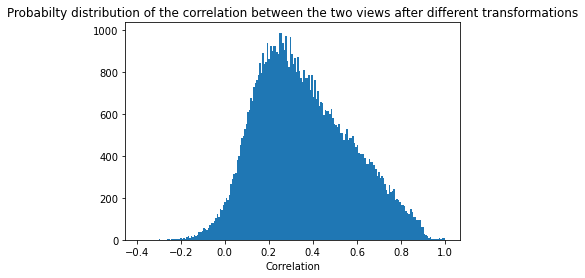

In [11]:
# Calculating the correlation between all the pairs of images of X and Y
cor_XY = [np.corrcoef(X[i].reshape(28*28),Y[i].reshape(28*28))[0][1] for i in range(len(data_set))]

# Plot the correlations
plt.hist(cor_XY, bins=200);
plt.xlabel('Correlation')
plt.title('Probabilty distribution of the correlation between the two views after different transformations');

In [12]:
# Create a function to plot X and Y pairs side by side
def plot_samples1(dataset_X, dataset_Y, label, num_samples=5):
    plt.figure(figsize=(num_samples*3, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset_X) - 1)
        x = dataset_X[idx]
        y = dataset_Y[idx]

        x_np = x.numpy().squeeze(0)
        y_np = y.numpy().squeeze(0)

        plt.subplot(2, num_samples, i + 1)
        plt.title('True = '+str(label[idx])+', Corr = '+str(np.round(np.corrcoef(x.reshape(28*28),y.reshape(28*28))[0][1],2)))
        plt.imshow(x_np, cmap="gray")
        plt.axis("off")

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(y_np, cmap="gray")
        plt.axis("off")

    plt.show()

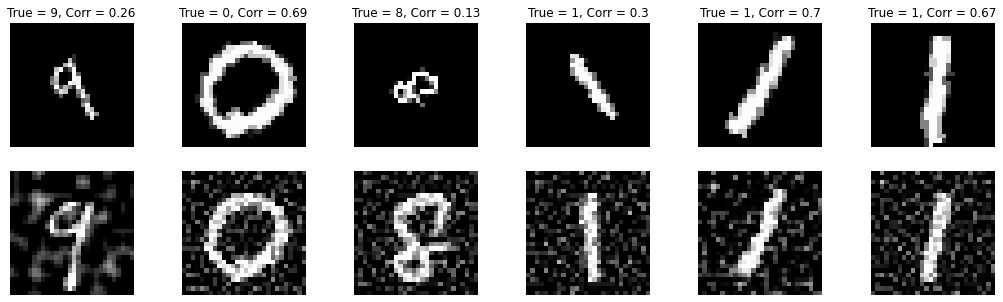

In [13]:
# Plot a few instances of X and Y pairs side by side
plot_samples1(X, Y, labels, 6)

In [16]:
# Split into training, validation, and testing, while maintaing the statstics
# Flatten the data to be ready for training after
X = [X[i].reshape(28*28) for i in range(len(data_set))]
Y = [Y[i].reshape(28*28) for i in range(len(data_set))]

# Create dictionaries to group data by labels
data_by_label = {label: [] for label in set(labels)}

# Use itertools.groupby to group by label in temp_x and temp_y
temp_x = {label: list(group) for label, group in groupby(
    sorted([[labels[i], theta[i], scales[i], X[i]] for i in range(len(data_set))], key=lambda x: x[0]), key=lambda x: x[0])}
temp_y = {label: list(group) for label, group in groupby(
    sorted([[labels[i], noise_factor[i], Y[i]] for i in range(len(data_set))], key=lambda x: x[0]), key=lambda x: x[0])}

# Shuffle whithin each group with the same label
for label, group in temp_x.items():
    random.shuffle(group)

for label, group in temp_y.items():
    random.shuffle(group)

# Concatenate the shuffled groups to get the final shuffled list for the views X and Y
temp_x = [elem for label in range(10) for elem in temp_x[label]]
temp_y = [elem for label in range(10) for elem in temp_y[label]]

for i, label in enumerate(labels):
    data_by_label[label].append((temp_x[i][3], temp_y[i][2], temp_x[i][0], temp_x[i][1], temp_x[i][2], temp_y[i][1]))
    # data_by_label[label].append((X[i], Y[i], label, theta[i], scales[i], noise_factor[i]))

# Define the proportion for each subset
train_ratio = 0.8
test_ratio = 0.1
validation_ratio = 0.1

# Initialize lists for each subset
train_set, test_set, validation_set = [], [], []

# Split data by labels into subsets
for label, data_list in data_by_label.items():
    random.shuffle(data_list)
    total_samples = len(data_list)

    train_size = int(total_samples * train_ratio)
    test_size = int(total_samples * test_ratio)

    train_set.extend(data_list[:train_size])
    test_set.extend(data_list[train_size:train_size + test_size])
    validation_set.extend(data_list[train_size + test_size:])

# Shuffle the subsets to ensure randomness
random.shuffle(train_set)
random.shuffle(test_set)
random.shuffle(validation_set)

# Extract X, Y, labels, theta, scale and noise factor for each subset, if regenerating
tr_X, tr_Y, tr_labels, tr_theta, tr_scale, tr_noise = zip(*train_set)
ts_X, ts_Y, ts_labels, ts_theta, ts_scale, ts_noise = zip(*test_set)
val_X, val_Y, val_labels, val_theta, val_scale, val_noise = zip(*validation_set)

In [17]:
# Create a dictionary to store the datasets
data_dict = {
    'train_X': np.array(tr_X),
    'train_Y': np.array(tr_Y),
    'train_labels': np.array(tr_labels),
    'train_theta': np.array(tr_theta),
    'train_scale': np.array(tr_scale),
    'train_noise': np.array(tr_noise),
    'test_X': np.array(ts_X),
    'test_Y': np.array(ts_Y),
    'test_labels': np.array(ts_labels),
    'test_theta': np.array(ts_theta),
    'test_scale': np.array(ts_scale),
    'test_noise': np.array(ts_noise),
    'validation_X': np.array(val_X),
    'validation_Y': np.array(val_Y),
    'validation_labels': np.array(val_labels),
    'validation_theta': np.array(val_theta),
    'validation_scale': np.array(val_scale),
    'validation_noise': np.array(val_noise)
}

# Save the dictionary to a file
np.savez('data.npz', **data_dict)


In [18]:
# Create a dictionary to store the datasets
data_dict_params = {
    'theta': theta,
    'scales': scales,
    'noise_factor': noise_factor,
}

# Save the dictionary to a file
np.savez('noisy_params.npz', **data_dict_params)


In [18]:
# # Load the dictionary from the file
# loaded_data = np.load('data.npz', allow_pickle=True)

# # Assign datasets to variables
# tr_X = loaded_data['train_X']
# tr_Y = loaded_data['train_Y']
# tr_labels = loaded_data['train_labels']
# tr_theta = loaded_data['train_theta']
# tr_scale = loaded_data['train_scale']
# tr_noise = loaded_data['train_noise']

# ts_X = loaded_data['test_X']
# ts_Y = loaded_data['test_Y']
# ts_labels = loaded_data['test_labels']
# ts_theta = loaded_data['test_theta']
# ts_scale = loaded_data['test_scale']
# ts_noise = loaded_data['test_noise']

# val_X = loaded_data['validation_X']
# val_Y = loaded_data['validation_Y']
# val_labels = loaded_data['validation_labels']
# val_theta = loaded_data['validation_theta']
# val_scale = loaded_data['validation_scale']
# val_noise = loaded_data['validation_noise']

In [ ]:
# # Load the dictionary from the file
# loaded_data_params = np.load('noisy_params.npz', allow_pickle=True)

# # Assign datasets to variables
# theta = loaded_data_params['theta']
# scales = loaded_data_params['scales']
# noise_factor = loaded_data_params['noise_factor']

In [19]:
# Create a function to plot X and Y pairs side by side
def plot_samples2(dataset_X, dataset_Y, label, num_samples=5):
    plt.figure(figsize=(num_samples*3, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset_X) - 1)
        x = dataset_X[idx]
        y = dataset_Y[idx]

        x_np = x.reshape(28,28)
        y_np = y.reshape(28,28)

        plt.subplot(2, num_samples, i + 1)
        plt.title('True = '+str(label[idx])+', Corr = '+str(np.round(np.corrcoef(x.reshape(28*28),y.reshape(28*28))[0][1],2)))
        plt.imshow(x_np.reshape(28,28), cmap="gray")
        plt.axis("off")

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(y_np.reshape(28,28), cmap="gray")
        plt.axis("off")

    plt.show()

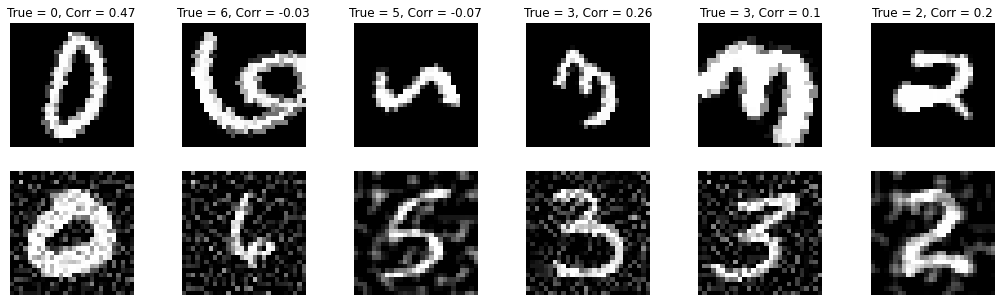

In [23]:
# Plot a few instances of X and Y pairs side by side
plot_samples2(tr_X, tr_Y, tr_labels, 6)